In [1]:
import rasa_core
from rasa_core.agent import Agent
from bokeh.io import output_notebook
agent = Agent.load("models/dialogue_embed")
# agent = Agent.load("models/dialogue_embed_before_norm_loss")
output_notebook()

/usr/local/lib/python3.6/site-packages/pykwalify/core.py:99: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  data = yaml.load(stream)


INFO:tensorflow:Restoring parameters from models/dialogue_embed/policy_0_EmbeddingPolicy/tensorflow_embedding.ckpt


Loading BokehJS ...

In [2]:
rasa_core.__version__

'0.12.0a4'

In [3]:
policy = agent.policy_ensemble.policies[0]
interpreter = agent.interpreter
print(policy.sparse_attention)

False


In [4]:
domain = agent.domain


In [5]:
from rasa_core.training.structures import StoryGraph
from rasa_core.training.dsl import StoryFileReader
from rasa_core.trackers import DialogueStateTracker
from rasa_core.channels import UserMessage
import numpy as np
np.set_printoptions(precision=3, suppress=True)

def embedding_from_tracker(story, bot=False, predict_only=False):
    reader = StoryFileReader(domain, interpreter)
    story = story.split('\n')
    story_steps = reader.process_lines(story)
#     story_graph = StoryGraph(story_steps)
    tracker = DialogueStateTracker(
            1,
            domain.slots
    )
    tracker._reset()
    for step in story_steps:
        events = step.explicit_events(domain)
        for event in events[:-1]:
            tracker.update(event)

    if predict_only:
        return policy.predict_action_probabilities(tracker, domain)

    data_X = policy.featurizer.create_X([tracker], domain)
    session_data = policy._create_tf_session_data(domain, data_X)
    all_Y_d_x = np.stack([session_data.all_Y_d for _ in range(session_data.X.shape[0])])
    feed_dict={policy.a_in: session_data.X,
               policy.b_in: all_Y_d_x,
               policy.c_in: session_data.slots,
               policy.b_prev_in: session_data.previous_actions,
               policy._dialogue_len: session_data.X.shape[1],
               policy._x_for_no_intent_in: session_data.x_for_no_intent,
               policy._y_for_no_action_in: session_data.y_for_no_action,
               policy._y_for_action_listen_in: session_data.y_for_action_listen}

    dial_vec = policy.session.run(policy.dial_embed, feed_dict=feed_dict)
    bot_vec = policy.session.run(policy.bot_embed, feed_dict=feed_dict)

    no_skip_gate = policy.session.run(policy.copy_attn_debug, feed_dict=feed_dict)
    attn_embed = policy.session.run(policy.attn_embed, feed_dict=feed_dict)
    rnn_embed = policy.session.run(policy.rnn_embed, feed_dict=feed_dict)
    probs = policy.session.run(policy.alignment_history, feed_dict=feed_dict)
    time_mask = policy.session.run(policy.all_time_masks, feed_dict=feed_dict)
    if probs.shape[2] == 2 * probs.shape[1]:
        user_probs = probs[0, -1, :int(probs.shape[2]/2)]
        bot_probs = probs[0, -1, int(probs.shape[2]/2):]
    else:
        user_probs = probs[0, -1, :]
        bot_probs = []

    sims = policy.session.run(policy.sim_op, feed_dict=feed_dict)
    if bot is False:
        sims1 = policy.predict_action_probabilities(tracker, domain)

    del tracker
#     print(np.shape(dial_vec))

    if bot is False:
        return (dial_vec[0,-1,:],
                no_skip_gate[0,-1,:],
                attn_embed[0,-1,:],
                rnn_embed[0,-1,:],
                [user_probs, bot_probs, time_mask[0,-1,:]],
                sims[0,-1,:],
                sims1)
    else:
        return (dial_vec[0,-1,:],
                sims[0,-1,:],
                bot_vec[0,-1,:,:])
    
def make_prediction(story):
    dial, sim0, bot = embedding_from_tracker(story, bot=True)
    abs_vals = np.array([np.absolute(vec) for vec in bot])
    norms = np.apply_along_axis(np.linalg.norm, 1, bot)
    sims = np.dot(bot, dial)/norms
#     name = domain.action_for_index(np.argmax(sims)).name()
#     print(name)
    name = domain.action_names[np.argmax(sim0)]
#     print(name)
#     print('---')
#     ids = sim0.argsort()[::-1]
#     print(ids)
#     print(sims[ids])
    return '- ' + name, np.max(sim0)
#     print(dial.shape, bot.shape)

In [20]:
# print(domain.intents)
story_block = """* request_hotel
    - utter_ask_details
* chitchat
    - utter_chitchat
    - utter_ask_details
* inform{"enddate": "May 26th"}
    - slot{"enddate": "May 26th"}
    - utter_ask_startdate
* inform{"startdate": "next week"}
    - slot{"startdate": "next week"}
    - utter_ask_location
* correct{"startdate": "next week"}
    - slot{"startdate": "next week"}
    - utter_correct_startdate_hotel
    - utter_ask_location
* explain
    - utter_explain_location_hotel
    - utter_ask_location
* inform{"location": "rome"}
    - slot{"location": "rome"}
    - utter_ask_price
* chitchat
    - utter_chitchat
    - utter_ask_price
* chitchat
    - utter_chitchat
    - utter_ask_price
* chitchat
    - utter_chitchat
    - utter_ask_price
* chitchat
    - utter_chitchat
    - utter_ask_price
* explain
    - utter_explain_price_hotel
    - utter_ask_price
* inform{"price": "expensive"}
    - utter_ask_people
* inform{"people": "4"}
    - utter_filled_slots
    - utter_search_hotel
    - slot{"hotel": "hotel"}
    - utter_suggest_hotel
* chitchat
    - utter_chitchat
    - utter_suggest_hotel
* affirm
    - utter_happy"""

In [21]:
# story_block = """* request_hotel
#     - utter_ask_details
# * inform{"people": "4"}
#     - slot{"people": "4"}
#     - utter_ask_location
# * correct{"people": "2"}
#     - slot{"people": "2"}
#     - utter_correct_people_hotel
#     - utter_ask_location
# * chitchat
#     - utter_chitchat
#     - utter_ask_location
# * inform{"location": "rome"}
#     - slot{"location": "rome"}
#     - utter_ask_price
# * inform{"price": "expensive"}
#     - slot{"price": "expensive"}
#     - utter_ask_startdate
# * inform{"startdate": "next week", "enddate": "tomorrow"}
#     - slot{"startdate": "next week"}
#     - slot{"enddate": "tomorrow"}
#     - utter_filled_slots
#     - utter_search_hotel
#     - slot{"hotel": "hotel"}
#     - utter_suggest_hotel
# * correct{"enddate": "May 26th"}
#     - slot{"enddate": "May 26th"}
#     - utter_correct_enddate_hotel
#     - utter_search_hotel
#     - slot{"hotel": "hotel"}
#     - utter_suggest_hotel
# * correct{"location": "rome"}
#     - slot{"location": "rome"}
#     - utter_correct_location_hotel
#     - utter_search_hotel
#     - slot{"hotel": "hotel"}
#     - utter_suggest_hotel
# * did_that_work
#     - utter_worked_hotel
#     - utter_suggest_hotel
# * affirm
#     - utter_happy
# * chitchat"""

In [22]:
# story_block = """* request_hotel
#     - utter_ask_details
# * inform{"people": "2"}
#     - slot{"people": "2"}
#     - utter_ask_location
# * correct{"people": "2"}
#     - slot{"people": "2"}
#     - utter_correct_people_hotel
#     - utter_ask_location
# * explain
#     - utter_explain_location_hotel
#     - utter_ask_location
# * inform{"location": "paris"}
#     - utter_ask_price
# * inform{"price": "expensive"}
#     - utter_ask_startdate
# * inform{"startdate": "10.03.2018"}
#     - utter_ask_enddate
# * explain
#     - utter_explain_enddate_hotel
#     - utter_ask_enddate
# * explain
#     - utter_explain_enddate_hotel
#     - utter_ask_enddate
# * explain
#     - utter_explain_enddate_hotel
#     - utter_ask_enddate
# * explain
#     - utter_explain_enddate_hotel
#     - utter_ask_enddate
# * did_that_work
#     - utter_more_info_hotel
#     - utter_ask_enddate
# * inform{"enddate": "10.03.2018"}
#     - utter_filled_slots
#     - utter_search_hotel
#     - slot{"hotel": "hotel"}
#     - utter_suggest_hotel
# * did_that_work
#     - utter_worked_hotel
#     - utter_suggest_hotel
# * affirm
#     - utter_happy
# """

In [23]:
print(len(story_block.split('\n')))
cool_list = []
lines = story_block.split('\n')
for idx, line in enumerate(lines):
    if idx == len(lines)-1:
        continue
    if '*' in lines[idx+1] or 'slot{' in lines[idx+1]:
#     if 'slot{' in lines[idx+1]:
        continue
    sub_story = '\n'.join(lines[:idx+1])
    (dial, not_skip, attn, rnn, probs, sims, sims1
    ) = embedding_from_tracker("#generate story\n{}".format(sub_story))
#     print(np.max(sims), np.max(sims1))

    pred, sim = make_prediction("#generate story\n{}".format(sub_story))
    cool_list.append((lines[idx+1].strip(), dial, (pred, sim, sims), not_skip, attn[-20:], rnn,
                      probs))
#     embedding_from_tracker("#generate story\n{}".format(sub_story), predict_only=True)

print(len(cool_list))
# print(cool_list[0][4].shape)
#     break
# dial = embedding_from_tracker("#generate story\n{}".format(story_block)
# )
# print(dial.shape)
# print(len(story_block.split('\n')))
# print(probs[0, 6, :])

48
27


In [35]:
import copy

# cool_list0 = copy.deepcopy(cool_list)
cool_list[11]

('- utter_ask_price',
 array([ 0.039, -0.05 ,  0.054,  0.03 ,  0.385, -0.162,  0.098, -0.076,
         0.213, -0.052, -0.081,  0.014,  0.116,  0.037,  0.077, -0.022,
        -0.253, -0.054, -0.002,  0.179], dtype=float32),
 ('- utter_ask_price',
  0.969217,
  array([-0.048, -0.003, -0.085,  0.026,  0.1  ,  0.079,  0.969, -0.148,
         -0.035, -0.057, -0.092,  0.006,  0.074, -0.015, -0.347, -0.226,
         -0.346, -0.302, -0.196, -0.293, -0.191,  0.019, -0.003, -0.39 ,
         -0.188, -0.032, -0.037, -0.035, -0.057,  0.007, -0.406, -0.25 ,
         -0.231, -0.008, -0.022, -0.394, -0.244, -0.514, -0.46 , -0.079,
         -0.052, -0.019,  0.017], dtype=float32)),
 array([1.   , 0.969, 0.   , 1.   , 0.   ], dtype=float32),
 array([ 0.034, -0.043,  0.058,  0.081,  0.236, -0.097,  0.057, -0.081,
         0.144, -0.048, -0.024,  0.   ,  0.103,  0.058,  0.076, -0.001,
        -0.164, -0.053, -0.013,  0.159], dtype=float32),
 array([ 0.005, -0.007, -0.004, -0.051,  0.148, -0.065,  0.041,  

In [36]:
# cool_list1= copy.deepcopy(cool_list)
cool_list[13]

('- utter_ask_price',
 array([ 0.038, -0.054,  0.055,  0.029,  0.394, -0.166,  0.099, -0.077,
         0.216, -0.049, -0.088,  0.011,  0.117,  0.033,  0.076, -0.02 ,
        -0.26 , -0.055,  0.001,  0.181], dtype=float32),
 ('- utter_ask_price',
  0.96681106,
  array([-0.048, -0.003, -0.086,  0.023,  0.108,  0.071,  0.967, -0.157,
         -0.035, -0.061, -0.093,  0.005,  0.084, -0.013, -0.343, -0.226,
         -0.342, -0.3  , -0.198, -0.286, -0.189,  0.023, -0.003, -0.389,
         -0.189, -0.035, -0.042, -0.034, -0.057,  0.006, -0.404, -0.252,
         -0.231, -0.004, -0.022, -0.385, -0.242, -0.513, -0.454, -0.08 ,
         -0.056, -0.023,  0.019], dtype=float32)),
 array([1.   , 0.967, 0.   , 1.   , 0.   ], dtype=float32),
 array([ 0.034, -0.043,  0.058,  0.081,  0.236, -0.097,  0.057, -0.081,
         0.144, -0.048, -0.024,  0.   ,  0.103,  0.058,  0.076, -0.001,
        -0.164, -0.053, -0.013,  0.159], dtype=float32),
 array([ 0.005, -0.011, -0.003, -0.052,  0.157, -0.068,  0.042,

In [12]:
import matplotlib.pyplot as plt
plt.plot(cool_list[15][-2], marker='x')

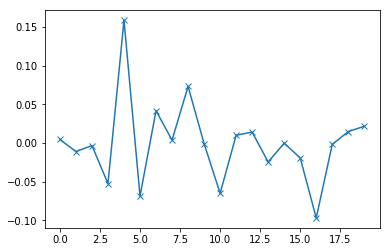

In [13]:
plt.plot(cool_list[19][-2], marker='x')

In [14]:
from sklearn.decomposition import PCA

In [15]:
pca = PCA(n_components=2)
X = pca.fit_transform([ting[1] for ting in cool_list])

In [16]:
from bokeh.plotting import figure, show
import matplotlib.pyplot as plt

In [17]:
embed_dim = cool_list[0][1].shape[0]


In [18]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, Arrow, OpenHead

hover = HoverTool(tooltips=[("true action","@desc"), ("prediction", "@pred"),
                            ("not_skip_gate", "@not_skip")],names=['circle'])
p = figure( tools=[hover])

for i in range(1, len(X)):
    p.add_layout(Arrow(end=OpenHead(line_color="firebrick", size=10, line_width=2),
                       x_start=X[i-1,0], y_start=X[i-1,1],
                       x_end=X[i,0], y_end=X[i,1], line_color='gray'))

source = ColumnDataSource(data=dict(
    x=X[:,0],
    y=X[:,1],
    desc=[ting[0] for ting in cool_list],
    pred = [ting[2][0] for ting in cool_list],
    not_skip = [ting[3][-1] for ting in cool_list]
))
p.circle('x','y', source=source, size=10, name='circle')
# p.line(X[:,0], X[:,1])

X1 = pca.transform([ting[4] for ting in cool_list])
source = ColumnDataSource(data=dict(
    x=X1[:,0],
    y=X1[:,1],
    desc=[ting[0] for ting in cool_list],
    pred = [ting[2][0] for ting in cool_list],
    not_skip = [ting[3][-1] for ting in cool_list]
))
p.circle('x','y', source=source, size=5, color='green', name='circle')

X2 = pca.transform([ting[5] for ting in cool_list])
source = ColumnDataSource(data=dict(
    x=X2[:,0],
    y=X2[:,1],
    desc=[ting[0] for ting in cool_list],
    pred = [ting[2][0] for ting in cool_list],
    not_skip = [ting[3][-1] for ting in cool_list]
))
p.circle('x','y', source=source, size=5, color='red', name='circle')

x = pca.transform(np.zeros((1,embed_dim)))
p.circle(x[0,0], x[0,1], size=5, color='magenta')
p.circle(X[0,0], X[0,1], size=10, color='green')
p.circle(X[-1,0], X[-1,1], size=10, color='red')


bokeh.models.renderers.GlyphRenderer(
    id='4ae725e7-b8de-4b32-adac-b3570c9de3b5',
    data_source=bokeh.models.sources.ColumnDataSource(
        id='3359c1b3-a3f6-4018-a858-31e759115287',
        callback=None,
        data={},
        js_event_callbacks={},
        js_property_callbacks={},
        name=None,
        selected=bokeh.models.selections.Selection(
            id='d81c3ef4-aa7b-47a9-b696-50e557a6ca01',
            indices=[],
            js_event_callbacks={},
            js_property_callbacks={},
            line_indices=[],
            multiline_indices={},
            name=None,
            subscribed_events=[],
            tags=[]),
        selection_policy=bokeh.models.selections.UnionRenderers(
            id='f6690a46-4d19-41e1-af0c-f149b2da494e',
            js_event_callbacks={},
            js_property_callbacks={},
            name=None,
            subscribed_events=[],
            tags=[]),
        subscribed_events=[],
        tags=[]),
    glyph=bokeh.models.markers.Circle(
        id='189b7106-df69-4aac-8617-b6094bdca4be',
        angle={'value': 0.0, 'units': 'rad'},
        fill_alpha={'value': 1.0},
        fill_color={'value': 'red'},
        js_event_callbacks={},
        js_property_callbacks={},
        line_alpha={'value': 1.0},
        line_cap='butt',
        line_color={'value': 'red'},
        line_dash=[],
        line_dash_offset=0,
        line_join='bevel',
        line_width={'value': 1},
        name=None,
        radius=None,
        radius_dimension='x',
        size={'value': 10, 'units': 'screen'},
        subscribed_events=[],
        tags=[],
        x={'value': 0.03182150336145036},
        y={'value': 0.0027050023283965107}),
    hover_glyph=None,
    js_event_callbacks={},
    js_property_callbacks={},
    level='glyph',
    muted=False,
    muted_glyph=None,
    name=None,
    nonselection_glyph=bokeh.models.markers.Circle(
        id='2cdf4a35-4377-45a9-8221-e727b5626770',
        angle={'value': 0.0, 'units': 'rad'},
        fill_alpha={'value': 0.1},
        fill_color={'value': '#1f77b4'},
        js_event_callbacks={},
        js_property_callbacks={},
        line_alpha={'value': 0.1},
        line_cap='butt',
        line_color={'value': '#1f77b4'},
        line_dash=[],
        line_dash_offset=0,
        line_join='bevel',
        line_width={'value': 1},
        name=None,
        radius=None,
        radius_dimension='x',
        size={'value': 10, 'units': 'screen'},
        subscribed_events=[],
        tags=[],
        x={'value': 0.03182150336145036},
        y={'value': 0.0027050023283965107}),
    selection_glyph=None,
    subscribed_events=[],
    tags=[],
    view=bokeh.models.sources.CDSView(
        id='c22f5376-6d82-4201-817a-4b1c2b5b8782',
        filters=[],
        js_event_callbacks={},
        js_property_callbacks={},
        name=None,
        source=bokeh.models.sources.ColumnDataSource(
            id='3359c1b3-a3f6-4018-a858-31e759115287',
            callback=None,
            data={},
            js_event_callbacks={},
            js_property_callbacks={},
            name=None,
            selected=bokeh.models.selections.Selection(
                id='d81c3ef4-aa7b-47a9-b696-50e557a6ca01',
                indices=[],
                js_event_callbacks={},
                js_property_callbacks={},
                line_indices=[],
                multiline_indices={},
                name=None,
                subscribed_events=[],
                tags=[]),
            selection_policy=bokeh.models.selections.UnionRenderers(
                id='f6690a46-4d19-41e1-af0c-f149b2da494e',
                js_event_callbacks={},
                js_property_callbacks={},
                name=None,
                subscribed_events=[],
                tags=[]),
            subscribed_events=[],
            tags=[]),
        subscribed_events=[],
        tags=[]),
    visible=True,
    x_range_name='default',
    y_range_name='default')

In [19]:
show(p)

In [18]:
print('utter_ask_price', '-->', domain.index_for_action('utter_ask_price'))
print('utter_ask_details', '-->', domain.index_for_action('utter_ask_details'))
print('utter_ask_people', '-->', domain.index_for_action('utter_ask_people'))
print('utter_explain_details_hotel', '-->', domain.index_for_action('utter_explain_details_hotel'))
print('utter_explain_people_hotel', '-->', domain.index_for_action('utter_explain_people_hotel'))
print('utter_explain_price_hotel', '-->', domain.index_for_action('utter_explain_price_hotel'))
print('utter_ask_location', '-->', domain.index_for_action('utter_ask_location'))
print('utter_explain_location_hotel', '-->', domain.index_for_action('utter_explain_location_hotel'))
print('utter_ask_startdate', '-->', domain.index_for_action('utter_ask_startdate'))
print('utter_suggest_hotel', '-->', domain.index_for_action('utter_suggest_hotel'))
print('action_search_hotel', '-->', domain.index_for_action('action_search_hotel'))
print('action_listen', '-->', domain.index_for_action('action_listen'))

utter_ask_price --> 6
utter_ask_details --> 28
utter_ask_people --> 4
utter_explain_details_hotel --> 14
utter_explain_people_hotel --> 19
utter_explain_price_hotel --> 21
utter_ask_location --> 5
utter_explain_location_hotel --> 17
utter_ask_startdate --> 7
utter_suggest_hotel --> 12
action_search_hotel --> 42
action_listen --> 0


In [19]:
utter_price = embedding_from_tracker("#generate story\n{}".format(story_block), bot=True)[0,-1,5,:]
utter_price.shape

(20,)

In [20]:
print(utter_price.shape)
x = pca.transform(utter_price.reshape(1,-1))
p.circle(x[0][0], x[0][1], color='black')

(20,)


GlyphRenderer(id='1db745d9-cfee-44a7-8a51-a238a358f252', ...)

In [21]:
show(p)

In [22]:
from collections import namedtuple

In [23]:
Point = namedtuple('Point', ['x', 'y'])
p = Point(11, y=22)
p._asdict()

OrderedDict([('x', 11), ('y', 22)])

In [24]:
Point3D = namedtuple('Point3D', Point._fields + ('z',))

In [25]:
p_asdict = p._asdict()
p_asdict['z'] = 3
p_asdict

OrderedDict([('x', 11), ('y', 22), ('z', 3)])

In [26]:
p3D = Point3D(**p_asdict)
p3D

Point3D(x=11, y=22, z=3)

In [27]:
x ={
        "day": "20",
        "month": "06",
        "year": "2018"
    }

In [28]:
x

{'day': '20', 'month': '06', 'year': '2018'}

In [29]:
def value_touched_dict(value):
    if isinstance(value, dict) and value.get("day"):
        value["value1"] = value.pop("day")
        value["value2"] = value.pop("month")
        value["value3"] = value.pop("year")
    return {"value": value,
            "touched": True}
value_touched_dict(x)

{'touched': True, 'value': {'value1': '20', 'value2': '06', 'value3': '2018'}}

In [30]:
value_touched_dict('x')

{'touched': True, 'value': 'x'}